<div class="markdown-google-sans">

# <strong>Bayesian Statistics `Regr`</strong>
> #### Gabriel L. S. Silva
</div>

In [ ]:
!pip install ucimlrepo --quiet

In [ ]:
from sklearn.metrics import silhouette_score
from ucimlrepo import fetch_ucirepo
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import numpy as np
import pymc as pm
import pytensor
import warnings

warnings.filterwarnings('ignore')
pytensor.config.cxx = ''
plt.style.use('bmh')

In [ ]:
raw = fetch_ucirepo(id=9)
df = raw.data.features
df['mpg'] = raw.data.targets
df.sample(3)

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
36,250.0,6,88.0,3302,15.5,71,1,19.0
53,71.0,4,65.0,1773,19.0,71,3,31.0
198,91.0,4,53.0,1795,17.4,76,3,33.0


>

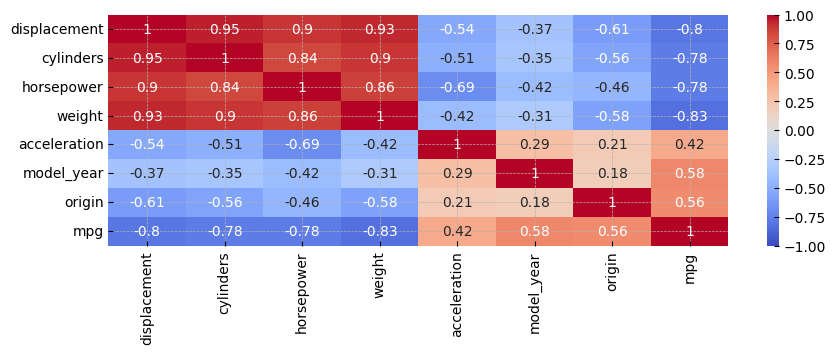

In [ ]:
plt.figure(figsize=(10, 3)) # prefiro plot retangular do que quadrado
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1);
# Removerei as variáveis que possuem altissima correlação

In [ ]:
df = df.drop(columns=['cylinders', 'horsepower'])

### Análise e Clusterização

In [ ]:
# Primeir a normalização geral, também será usado para os outros modelos
features_cluster = ['acceleration', 'origin']
features = ['weight', 'displacement'] # Todas as features aqui

features_scaled = df[features].apply(lambda x: (x-x.mean())/x.std())
features_scaled.sample(2)

,weight,displacement
325,-1.045561,-0.991906
196,-0.952273,-0.915182


> Para cada k, aqui calcula a inércia, e para o número de clusters que aumenta, a inércia diminui porque os pontos ficam mais próximos dos centros dos cluster, e nesse caso, eu pego o k cluster onde num certo ponto, se eu adicionar mais clusters, meu desempenho no modelo poderá não ter diferença ou até piorar
- No caso aqui, 3 cluster parece aceitavel

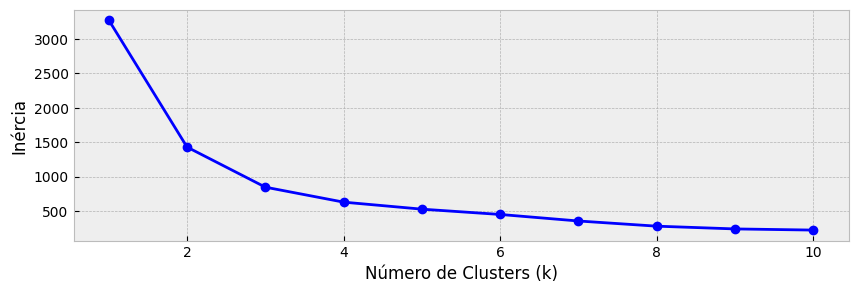

In [ ]:
inertia = [KMeans(n_clusters=k, random_state=42).fit(df[features_cluster]).inertia_ for k in range(1, 11)]
plt.figure(figsize=(10, 3))
plt.plot(range(1, 11), inertia, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia'); # 3 parece aceitavel

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster = kmeans.fit_predict(df[features_cluster])

df['cluster'] = cluster
df['cluster'].value_counts()

,count
cluster,
0,207
2,99
1,92


### **Criação do Modelo 01**
> Regressão Hierarquica

In [ ]:
# Aqui eu posso ver que não existem valores abaixo de zero
df['mpg'].max(), df['mpg'].min()

(46.6, 9.0)

In [ ]:
coords = {'features': features}

with pm.Model(coords=coords) as hierarchical:
  alpha = pm.Normal('alpha', mu=0, sigma=10, shape=3)
  betas = pm.Normal('betas', mu=0, sigma=10, dims='features')
  sigma = pm.HalfNormal('sigma', sigma=10)

  mu = pm.math.dot(df[features], betas) + alpha[cluster]
  likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=df['mpg'])

In [ ]:
with hierarchical:
  tc_prior_hier = pm.sample_prior_predictive()

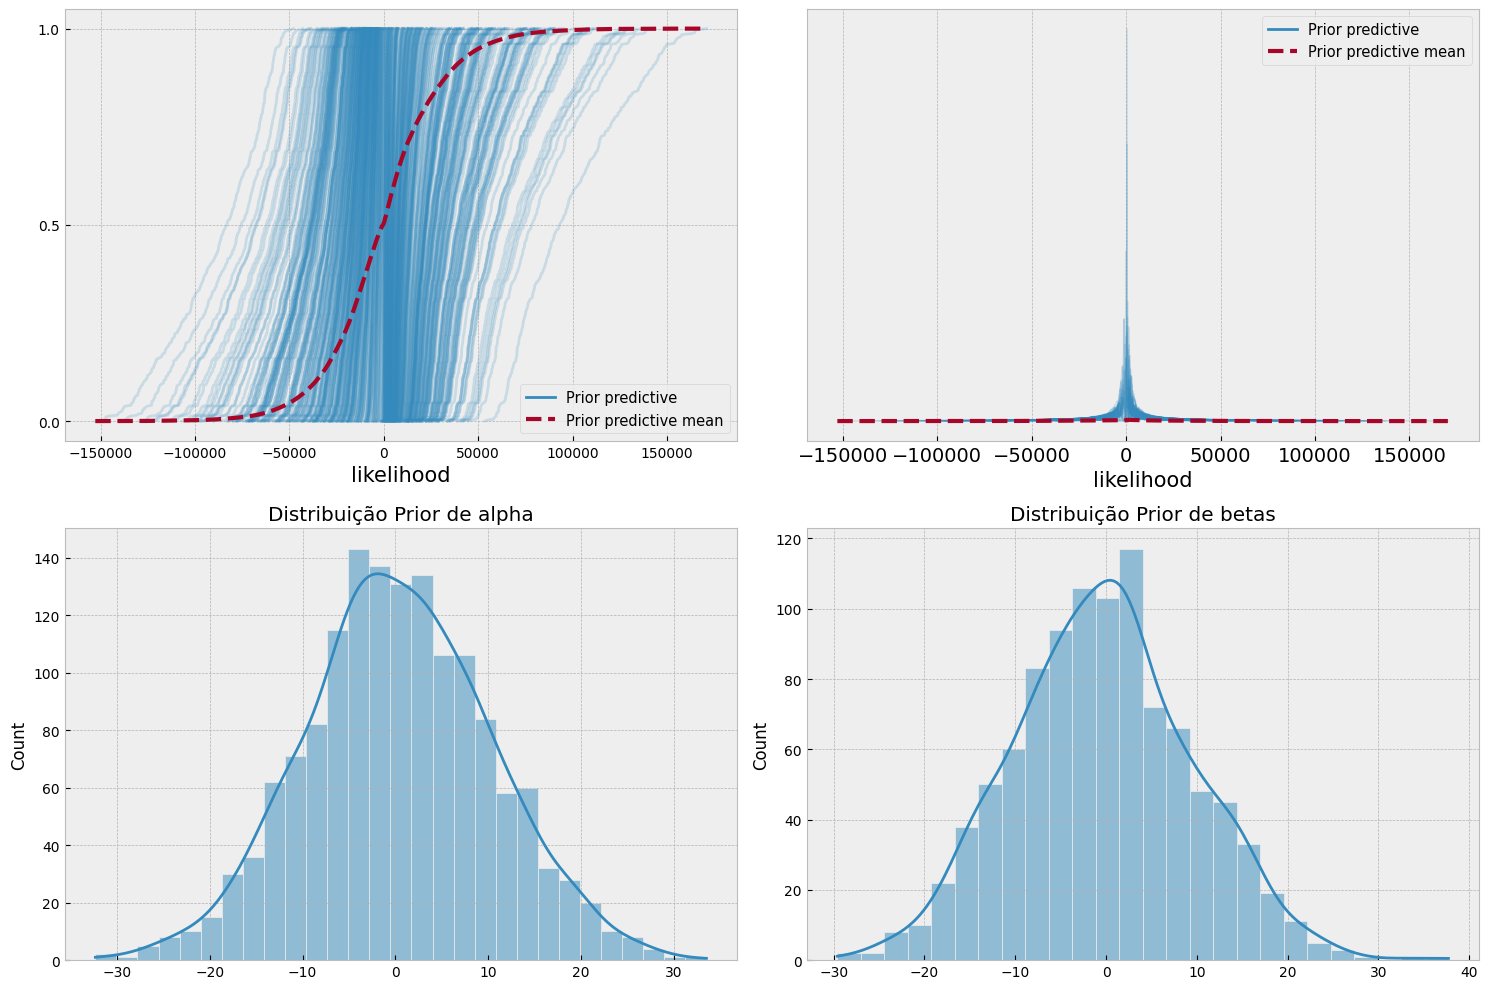

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

az.plot_ppc(tc_prior_hier, group='prior', kind='cumulative', ax=axes[0, 0])
az.plot_ppc(tc_prior_hier, group='prior', ax=axes[0, 1])
for i, param in enumerate(['alpha', 'betas']):
    sns.histplot(tc_prior_hier.prior[param].values.flatten(), kde=True, ax=axes[1, i])
    axes[1, i].set_title(f'Distribuição Prior de {param}')

plt.tight_layout(); plt.show();

### Motivo do Uso do .fit()
> Após várias tentativas e a seleção de outras features, a ultima escolha foi utilizar o fit, que realiza a inferencia por métodos variacionais, que são uma aproximação ao método completo, e que eu posso usar no lugar de pm.sample() nesse caso
![](https://raw.githubusercontent.com/gabrielluizone/Predictive-Analysis/refs/heads/main/prints/Captura%20de%20tela%202024-09-26%20115529.png)

In [ ]:
with hierarchical:
    trace_hier = pm.fit()

Output()

In [ ]:
pm.summary(trace_hier)

ValueError: Can only convert xarray dataarray, xarray dataset, dict, pytree, netcdf filename, numpy array, pystan fit, emcee fit, pyro mcmc fit, numpyro mcmc fit, cmdstan fit csv filename, cmdstanpy fit to InferenceData, not MeanField

In [ ]:
az.plot_posterior(trace_hier)

In [ ]:
a_samples = trace_hier.posterior["a"].values.flatten()
b_samples = trace_hier.posterior["b"].values.flatten()
t_values = np.linspace(t.min(), t.max(), 100)

for a_sample, b_sample in zip(a_samples, b_samples):
    plt.plot(t_values, a_sample + b_sample * t_values, color="blue", alpha=0.05)

mean_a = a_samples.mean()
mean_b = b_samples.mean()
plt.plot(t_values, mean_a + mean_b * t_values, color="orange", label="Reta de Regressão Média")

#plt.scatter(t, obs, color="red", label="Observed Data", alpha=0.5)

plt.xlabel("Temperatura (°C)")
plt.ylabel("Rendimento da Colheita (hg/ha)")
plt.title("Linhas de Regressão - Posteriori")
plt.legend()
plt.show()

> Pela análise de todos os betas, temos que o modelo teve uma boa convergência dos dados, pelo valor do `r_hat` sendo 1. Podemos ver isso visualmente abaixo

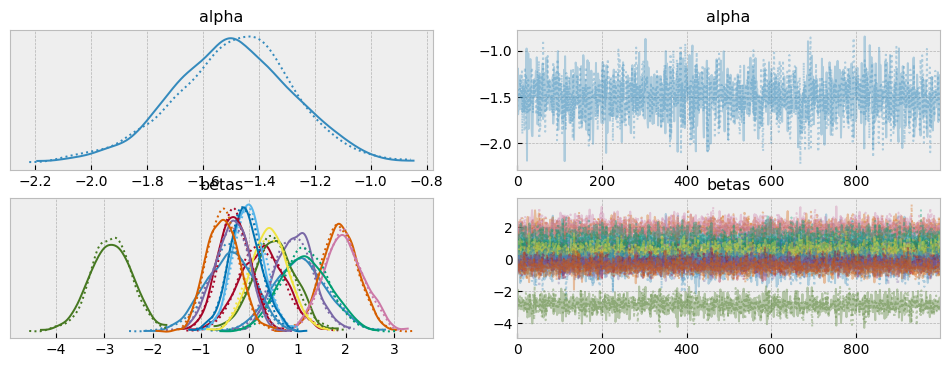

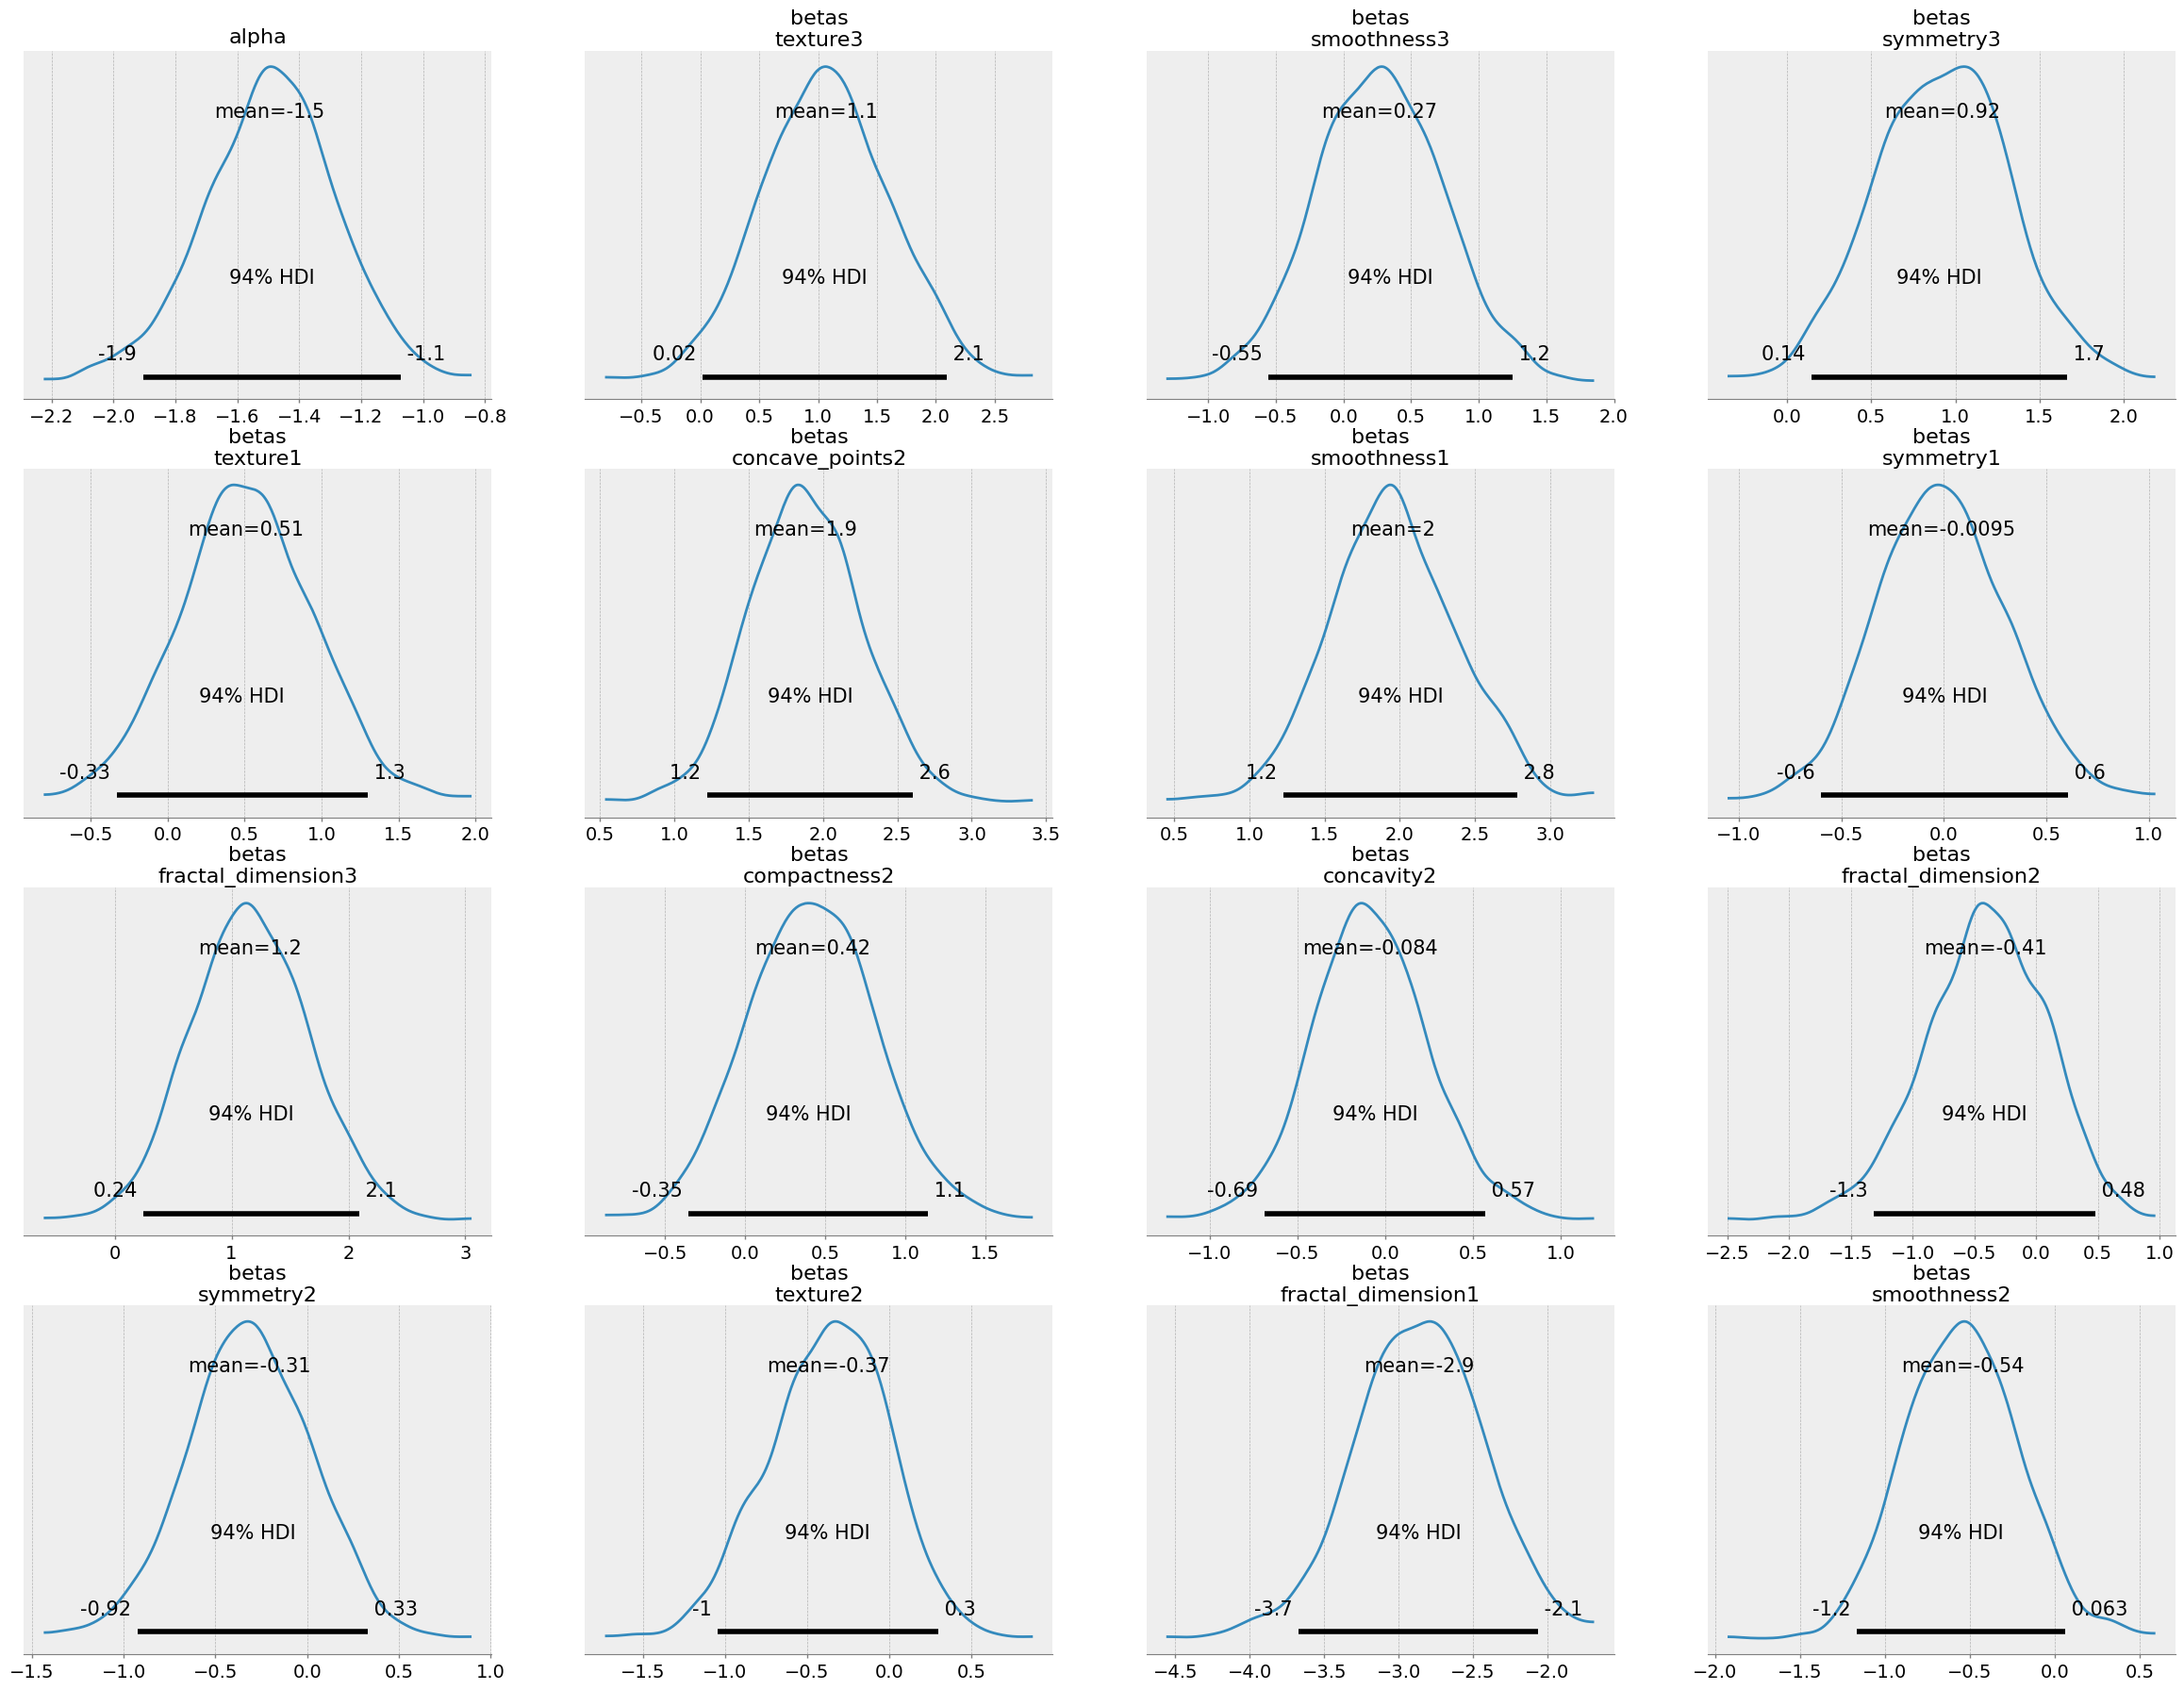

In [ ]:
az.plot_trace(trace)
az.plot_posterior(trace, hdi_prob=.94);

### Realizando Teste do Modelo

In [ ]:
vars = {'X': X_test.values, 'y': y_test.values}

In [ ]:
with logit_model:
  pm.set_data(vars)
  trace_post = pm.sample_posterior_predictive(trace)

mean_likelihood = trace_post.posterior_predictive['likelihood'].mean(dim=['chain', 'draw'])
bin_pred = (mean_likelihood > .5).astype(int)
abs_diff = abs(y_test - bin_pred)

ds = pd.DataFrame({'y_test': y_test, 'predict': bin_pred, 'abs_diff': abs_diff})
ds.T # Aqui eu transposto o dataset para melhorar a visualização dele

Output()

,448,346,568,411,519,527,4,440,479,310,...,88,130,71,60,459,74,39,99,115,219
y_test,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,1,0,1
predict,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
abs_diff,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


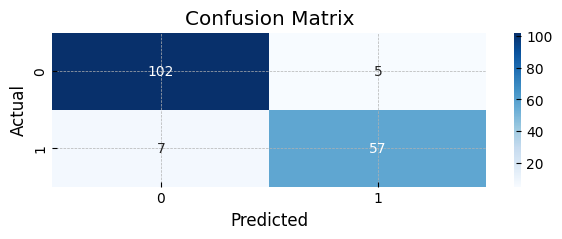

In [ ]:
cm = confusion_matrix(ds['y_test'], ds['predict'])
plt.figure(figsize=(7, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
acc = accuracy_score(y_test, bin_pred)
pre = precision_score(y_test, bin_pred)
rcl = recall_score(y_test, bin_pred)
f1 = f1_score(y_test, bin_pred)

print(f"• Acurácia: {acc:.4f}")
print(f"Precisão: {pre:.4f}")
print(f"Recall: {rcl:.4f}")
print(f"F1 Score: {f1:.4f}")

• Acurácia: 0.9298
Precisão: 0.9194
Recall: 0.8906
F1 Score: 0.9048


## **Conslusão**
> O modelo construido convergiu bem com os dados, e tivemos bons resultados com o conjunto de teste, resultando em uma acurárica de 92%. Em relação a existir poucos caso positivos (considero 1 como positivo), a seleção do conjunto de treino e teste foi estratificado para que a proporção do target fosse o mesmo, por essa razão, consideros que os resultados, possivelmente  não estejam enviasados. Obrigado